<h1 style="color: green;">Summary</h1>
<p style="color: black;">
In this section the following tasks are accomplished:
<ul>
<li>Data extraction from database </li>
<li>New features creation</li>
<li>Target/label definition</li>
<li>Export the raw data to csv format</li>
</ul>
</p>


<h1 style="color: green;">Importing libraries</h1>

In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# SQLAlchemy==1.4.35
import sqlalchemy

# preliminary feature selection
from feature_engine.selection import DropConstantFeatures
from sklearn.feature_selection import VarianceThreshold

# environment variables
from dotenv import load_dotenv

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading environment variables
load_dotenv()

True

<h1 style="color: green;">Connecting to database</h1>

In [3]:
sqlUrl = sqlalchemy.engine.URL.create(
    drivername = os.getenv('drivername'),
    username = os.getenv('username'),
    password = os.getenv('password'),
    host = os.getenv('host'),
    port = os.getenv('port'),
    database = os.getenv('database')
)

engine = sqlalchemy.create_engine(sqlUrl)

<h3 style="color: green;">Reading data</h3>

In [4]:
# Reading receipt table

Receipt = pd.read_sql_table("receipt", engine)

print(Receipt.shape)
Receipt.tail()


(905, 10)


,Receipt_id,Venue_id,Total_Nbr_of_Items,Total_Price,Receipt_Nbr,Trans_number,Barcode,Receipt_Date,Receipt_Time,Date_Added
900,911,3,1,1.80,21052023121600,0,0,2023-05-21,12:16:00,2023-05-21 14:09:00
901,912,53,1,10.99,23052023101400,0,0,2023-05-23,10:14:00,2023-05-23 10:30:49
902,913,36,16,18.67,26052023161414,0,0,2023-05-26,16:14:14,2023-05-26 19:47:03
903,914,22,1,19.48,28052023161800,0,0,2023-05-28,16:18:00,2023-05-29 17:41:52
904,915,22,1,23.98,29052023085600,0,0,2023-05-29,08:56:00,2023-05-29 17:47:33


In [5]:
# Reading in Venue details
Venue_details = pd.read_sql_table("venue_details", engine)

Venue_details[['Venue_id','Venue']].head()

,Venue_id,Venue
0,1,Aldi
1,2,B&Q
2,3,Wilko
3,4,Sports direct.com
4,5,Europe


In [6]:
# Reading payment table
Payment = pd.read_sql_table("payment", engine)
Payment[['Payment_id','Receipt_id','Payment_Type','Card_Source','Date_Added']].head()

,Payment_id,Receipt_id,Payment_Type,Card_Source,Date_Added
0,1,1,Card,Contactless,2020-07-23 18:34:35
1,2,2,Card,Contactless,2020-07-23 20:29:03
2,3,3,Card,Contactless,2020-07-23 20:54:53
3,4,4,Card,Contactless,2020-07-23 21:15:05
4,5,5,Card,Contactless,2020-07-23 21:32:10


In [7]:
# Reading item table
Item = pd.read_sql_table("item", engine)
Item.tail()

,Item_id,Venue_id,Receipt_id,Venue_Item_code,Item_name,Item_Price,Date_Added
5069,5130,36,913,0,Brown onions,1.10,2023-05-26 19:47:03
5070,5131,36,913,0,Chicken thighs,3.14,2023-05-26 19:47:03
5071,5132,36,913,0,Chicken thighs,3.14,2023-05-26 19:47:03
5072,5133,22,914,0,Bonnlo multi-use glass kettle 1.8l,19.48,2023-05-29 17:41:52
5073,5134,22,915,0,Tripod for iPhone/iPad by PemoTech 42 inch,23.98,2023-05-29 17:47:33


<h3 style="color: green;">Merging the tables to create the raw data</h3>

<h5 style="color: green;">Merging Venue_details to Receipt</h5>

In [8]:
# Merging Venue_details with Receipt to retrieve Venue
Receipt = pd.merge(Receipt, 
                   Venue_details[['Venue_id','Venue']], 
                   on='Venue_id', how='left')
Receipt.head()

,Receipt_id,Venue_id,Total_Nbr_of_Items,Total_Price,Receipt_Nbr,Trans_number,Barcode,Receipt_Date,Receipt_Time,Date_Added,Venue
0,1,1,8,6.78,1488772027005024,0,0,2020-05-28,11:09:45,2020-07-23 18:25:38,Aldi
1,2,1,9,6.32,1173772027004007,0,0,2020-06-24,12:57:56,2020-07-23 20:25:36,Aldi
2,3,1,9,7.44,6880772027011805,0,0,2020-07-01,14:28:27,2020-07-23 20:51:18,Aldi
3,4,1,12,8.27,7450772027005024,0,0,2020-06-10,13:07:51,2020-07-23 21:13:19,Aldi
4,5,1,11,8.10,3851772027003031,0,0,2020-05-25,11:31:37,2020-07-23 21:30:04,Aldi


<h5 style="color: green;">Merging Payment to Receipt</h5>

In [9]:
# merging Payment to Receipt for the analysis
Receipt_Payment = pd.merge(Receipt, 
                           Payment[['Receipt_id','Payment_Type','Card_Source']], 
                           on='Receipt_id', how='left')
Receipt_Payment.head()

,Receipt_id,Venue_id,Total_Nbr_of_Items,Total_Price,Receipt_Nbr,Trans_number,Barcode,Receipt_Date,Receipt_Time,Date_Added,Venue,Payment_Type,Card_Source
0,1,1,8,6.78,1488772027005024,0,0,2020-05-28,11:09:45,2020-07-23 18:25:38,Aldi,Card,Contactless
1,2,1,9,6.32,1173772027004007,0,0,2020-06-24,12:57:56,2020-07-23 20:25:36,Aldi,Card,Contactless
2,3,1,9,7.44,6880772027011805,0,0,2020-07-01,14:28:27,2020-07-23 20:51:18,Aldi,Card,Contactless
3,4,1,12,8.27,7450772027005024,0,0,2020-06-10,13:07:51,2020-07-23 21:13:19,Aldi,Card,Contactless
4,5,1,11,8.10,3851772027003031,0,0,2020-05-25,11:31:37,2020-07-23 21:30:04,Aldi,Card,Contactless


<h3 style="color: green;">Engineering receipt features before merge with item data</h3>

In [10]:
# Excluding refunds i.e. negative Total_Price
print(f"The shape with refunds: {Receipt_Payment.shape}")
Receipt_Payment = Receipt_Payment[Receipt_Payment.Total_Price > 0]
print(f"The shape without refunds: {Receipt_Payment.shape}")

# Checking to see that the exclusion was done correctly
Receipt_Payment.query("Total_Price < 0")

The shape with refunds: (905, 13)
The shape without refunds: (888, 13)


,Receipt_id,Venue_id,Total_Nbr_of_Items,Total_Price,Receipt_Nbr,Trans_number,Barcode,Receipt_Date,Receipt_Time,Date_Added,Venue,Payment_Type,Card_Source


In [11]:
# Deriving the difference in days between shopping trips

# sorting the data in ascending date order
Receipt_Payment.sort_values('Receipt_Date',ascending=True, inplace=True)
print(Receipt_Payment.shape)

# calculating the date difference using the shift() method to get the lag -1 value
# and retrieving the numeric part of date difference
Receipt_Payment['Date_diff'] = (Receipt_Payment.Receipt_Date - Receipt_Payment.Receipt_Date.shift()).dt.days

# Deriving the weekdate
Receipt_Payment['Week_day_numeric'] = Receipt_Payment['Receipt_Date'].dt.dayofweek + 1
Receipt_Payment['Week_day_name'] = Receipt_Payment['Receipt_Date'].dt.day_name()


(888, 13)


In [12]:
Receipt_Payment[['Receipt_Date','Date_diff','Week_day_numeric','Week_day_name']].head()

,Receipt_Date,Date_diff,Week_day_numeric,Week_day_name
96,2019-09-20,NaN,5,Friday
97,2019-09-20,0.0,5,Friday
95,2019-09-20,0.0,5,Friday
142,2019-09-25,5.0,3,Wednesday
98,2019-09-26,1.0,4,Thursday


In [13]:
# concatenate year and week to retrieve week of the year
Receipt_Payment['week_of_year'] = Receipt_Payment.Receipt_Date.dt.isocalendar().year.map(str)+ "_" +  \
Receipt_Payment.Receipt_Date.dt.isocalendar().week.map(str)


In [14]:
Receipt_Payment[['Receipt_id','Receipt_Date','week_of_year']].tail()

,Receipt_id,Receipt_Date,week_of_year
900,911,2023-05-21,2023_20
901,912,2023-05-23,2023_21
902,913,2023-05-26,2023_21
903,914,2023-05-28,2023_21
904,915,2023-05-29,2023_22


In [15]:
# Calculate the number of trips per week
Receipt_Payment['Nbr_trips_per_wk'] = Receipt_Payment.groupby(['week_of_year'])['Receipt_id'].transform('count')

# Calculate number of items bought per week
Receipt_Payment['Nbr_items_per_wk'] = Receipt_Payment.groupby(['week_of_year'])\
                            ['Total_Nbr_of_Items'].transform('sum')

# Calculating receipt Total_Nbr_of_Items as a percentage of the weeks Total_Nbr_of_Items 
Receipt_Payment['Nbr_items_wk_perc'] = Receipt_Payment.Total_Nbr_of_Items / Receipt_Payment.Nbr_items_per_wk

# Calculate expenditure per week
Receipt_Payment['Expenditure_per_wk'] = Receipt_Payment.groupby(['week_of_year'])['Total_Price'].transform('sum')

# Calculating receipt Total_Price as a percentage of the weeks expenditure
Receipt_Payment['Total_Exp_wk_perc'] = Receipt_Payment.Total_Price / Receipt_Payment.Expenditure_per_wk

# Calculate average expenditure per week for item
Receipt_Payment['AVG_exp_item_per_wk'] = Receipt_Payment['Expenditure_per_wk']\
/ Receipt_Payment['Nbr_items_per_wk'] 

In [16]:
Receipt_Payment[['Receipt_id','Receipt_Date','week_of_year',
                 'Nbr_trips_per_wk','Nbr_items_per_wk','Nbr_items_wk_perc',
                 'Expenditure_per_wk','Total_Exp_wk_perc','AVG_exp_item_per_wk']].tail()

,Receipt_id,Receipt_Date,week_of_year,Nbr_trips_per_wk,Nbr_items_per_wk,Nbr_items_wk_perc,Expenditure_per_wk,Total_Exp_wk_perc,AVG_exp_item_per_wk
900,911,2023-05-21,2023_20,11,52,0.019231,153.19,0.011750,2.945962
901,912,2023-05-23,2023_21,3,18,0.055556,49.14,0.223647,2.730000
902,913,2023-05-26,2023_21,3,18,0.888889,49.14,0.379935,2.730000
903,914,2023-05-28,2023_21,3,18,0.055556,49.14,0.396418,2.730000
904,915,2023-05-29,2023_22,1,1,1.000000,23.98,1.000000,23.980000


<h1 style="color: green;">Creating the target, trips_response</h1>
<p style="color: black;">
This is  a binary response(target) feature/variable.<br>
If the number of trips per week is less than a threshold then 1 else 0
</p>

In [17]:
# Printing the value counts for Nbr_trips_per_wk 
# This will aid the decision as to how to classify the response target
Nbr_trips_per_wk_pivot = pd.pivot_table(Receipt_Payment, 
                           index='Nbr_trips_per_wk',
                           values='Receipt_id', 
                           aggfunc='count')
Nbr_trips_per_wk_pivot

,Receipt_id
Nbr_trips_per_wk,
1,12
2,28
3,66
4,112
5,180
6,144
7,63
8,48
9,63


In [18]:
# Creating several versions of the target for comparison
Receipt_Payment['Trips_response_lt_4'] = Receipt_Payment.Nbr_trips_per_wk.apply(lambda x: 1 if x < 4 else 0)
Receipt_Payment['Trips_response_lt_5'] = Receipt_Payment.Nbr_trips_per_wk.apply(lambda x: 1 if x < 5 else 0)
Receipt_Payment['Trips_response_lt_6'] = Receipt_Payment.Nbr_trips_per_wk.apply(lambda x: 1 if x < 6 else 0)

In [19]:
Receipt_Payment[['week_of_year',
         'Nbr_trips_per_wk','Trips_response_lt_4',
         'Trips_response_lt_5','Trips_response_lt_6']].query("Trips_response_lt_6==1 and Trips_response_lt_5 != 1").tail()

,week_of_year,Nbr_trips_per_wk,Trips_response_lt_4,Trips_response_lt_5,Trips_response_lt_6
863,2023_17,5,0,0,1
864,2023_17,5,0,0,1
867,2023_17,5,0,0,1
866,2023_17,5,0,0,1
865,2023_17,5,0,0,1


In [20]:
# Displaying the frequencies for Trips_response_lt_4
response_pivot = pd.pivot_table(Receipt_Payment, 
                           index='Trips_response_lt_4',
                           values='Receipt_id', 
                           aggfunc='count')
response_pivot

,Receipt_id
Trips_response_lt_4,
0,782
1,106


In [21]:
Receipt_Payment.Trips_response_lt_4.value_counts(normalize=True)

0    0.880631
1    0.119369
Name: Trips_response_lt_4, dtype: float64

In [22]:
# Displaying the frequencies for Trips_response_lt_5
response_pivot = pd.pivot_table(Receipt_Payment, 
                           index='Trips_response_lt_5',
                           values='Receipt_id', 
                           aggfunc='count')
response_pivot

,Receipt_id
Trips_response_lt_5,
0,670
1,218


In [23]:
Receipt_Payment.Trips_response_lt_5.value_counts(normalize=True)

0    0.754505
1    0.245495
Name: Trips_response_lt_5, dtype: float64

In [24]:
# Displaying the frequencies for Trips_response_lt_6
response_pivot = pd.pivot_table(Receipt_Payment, 
                           index='Trips_response_lt_6',
                           values='Receipt_id', 
                           aggfunc='count')
response_pivot

,Receipt_id
Trips_response_lt_6,
0,490
1,398


In [25]:
Receipt_Payment.Trips_response_lt_6.value_counts(normalize=True)

0    0.551802
1    0.448198
Name: Trips_response_lt_6, dtype: float64

<h3 style="color: Green;">Working with imbalanced data</h3>
<p style="color: black;">
Classification models have a bias that predicts best the class with the largest number<br>
of observations. So it is important to select a response feature that is well represented<br>
in the data to generate adequate predictions:<br><br>
Trips_response_lt_4 has the smallest representation of the target 106(12%), not as desireable <br>for modelling purposes.<br><br>
However, 4 trips per week is practically ideal as it minimises the number of trips despite the lowering of<br>target, response of interest number of observations i.e. I prefer to do less running around shopping<br><br>    
Trips_response_lt_6 has the largest representation of the target 398(45%) this is excellent <br> as almost 50% of the observations are the response of interest.<br>
However, the inclusion of 5 trips a week is too many when I am considering optimizing the<br>
number of trips per week.<br><br>
Trips_response_lt_5 is the middle ground with representation of the target 218(24%).<br>
So modelling Trips_response_lt_5 is preferred.
</p>
<p style="color: black;"><b>
Later on, we will balance the training dataset with oversampling method<br>
and then re-run the models for comparison.</b>
</p>

In [26]:
Trips_per_week_ = pd.pivot_table(Receipt_Payment, index='Nbr_trips_per_wk', 
               columns='Trips_response_lt_5', 
               values='Venue_id',
               aggfunc='count').fillna(0)

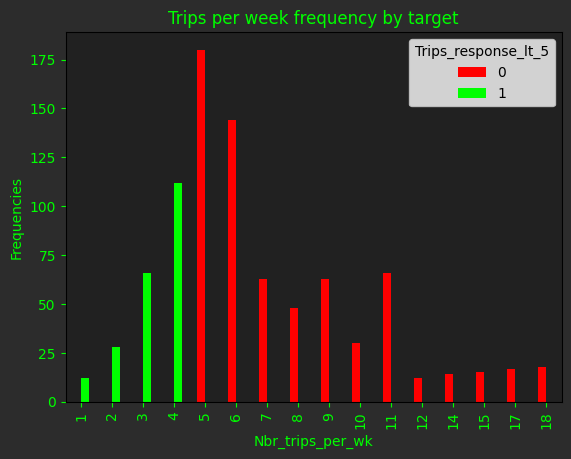

In [27]:
# plotting the above for visual illustration
# figure background
fig = plt.figure()
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax = fig.add_subplot(111)
ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')

Trips_per_week_.plot(ax=ax,
                kind='bar', 
                ylabel='Frequencies',
                title='Trips per week frequency by target', 
                color=['red','lime'])
plt.show()

In [28]:
# dropping ['Trips_response_lt_4','Trips_response_lt_6']
Receipt_Payment.drop(['Trips_response_lt_4','Trips_response_lt_6'], axis=1, inplace=True)

<h1 style="color: green;">Creating part of the day features</h1>

In [29]:
# extract the time of day as morning, afternoon, evening etc
Receipt_Payment['hour'] = Receipt_Payment['Receipt_Time'].apply(lambda x: x.hour)

bins_= [0,7,11,17,20,23]
lbl = ['Early','Morning','Afternoon','Evening','Late_night']

Receipt_Payment['Part_of_day'] = pd.cut(Receipt_Payment['hour'],bins=bins_, labels=lbl, include_lowest=True)


In [30]:
Receipt_Payment[['Receipt_Time', 'hour','Part_of_day']].tail()

,Receipt_Time,hour,Part_of_day
900,12:16:00,12,Afternoon
901,10:14:00,10,Morning
902,16:14:14,16,Afternoon
903,16:18:00,16,Afternoon
904,08:56:00,8,Morning


In [31]:
# Checking the frequencies of part of day
y = Receipt_Payment.Part_of_day.value_counts(normalize=True)
y

Afternoon     0.495495
Morning       0.326577
Evening       0.121622
Early         0.031532
Late_night    0.024775
Name: Part_of_day, dtype: float64

<h5 style="color: green;">Merging item data</h5>

In [32]:
# merging item to Receipt_Payment
raw0 = pd.merge(Receipt_Payment,
                     Item[['Receipt_id','Item_id','Item_name','Item_Price']], 
                     on='Receipt_id', 
                     how='left' )

In [33]:
raw0.head()

,Receipt_id,Venue_id,Total_Nbr_of_Items,Total_Price,Receipt_Nbr,Trans_number,Barcode,Receipt_Date,Receipt_Time,Date_Added,...,Nbr_items_wk_perc,Expenditure_per_wk,Total_Exp_wk_perc,AVG_exp_item_per_wk,Trips_response_lt_5,hour,Part_of_day,Item_id,Item_name,Item_Price
0,100,12,1,2.98,0,0,05-03896-06921,2019-09-20,13:10:00,2020-11-02 17:34:49,...,0.333333,17.16,0.173660,5.7200,1,13,Afternoon,694,Iron wire silver 1 roll,2.98
1,101,12,1,3.29,0,0,05-03896-06922,2019-09-20,13:10:00,2020-11-02 17:45:31,...,0.333333,17.16,0.191725,5.7200,1,13,Afternoon,695,Copper wire round unplated,3.29
2,99,12,1,10.89,0,0,25-03894-02600,2019-09-20,11:24:00,2020-11-02 17:23:49,...,0.333333,17.16,0.634615,5.7200,1,11,Morning,693,Fan Heater electric cooler,10.89
3,146,10,1,10.00,0,0,0,2019-09-25,08:00:00,2020-12-17 10:17:41,...,0.250000,28.69,0.348554,7.1725,1,8,Morning,901,Membership Payment,10.00
4,102,12,1,5.91,0,0,20-03919-91256,2019-09-26,12:05:00,2020-11-02 21:10:24,...,0.250000,28.69,0.205995,7.1725,1,12,Afternoon,696,Multimeter Voltmeter,5.91


In [34]:
raw0.shape

(5054, 29)

<h1 style="color: green;">Grouping items and creating new features</h1>

In [35]:
# breads
nots = ['garlic','Ham','Garlic','ham']
ins = ['Bread','bloomer','bread','Bloomer']

raw0['Bread'] = raw0.Item_name.apply(lambda sentence: 1 if any(word in sentence for word in ins) 
                            and not any(word in sentence for word in nots) else 0)

In [36]:
# Check that the bread indicator output
raw0[['Item_name','Item_Price','Bread']].query("Bread == 1").tail()

,Item_name,Item_Price,Bread
4940,Bread,0.95,1
4941,Bread,0.95,1
4969,Bread,1.00,1
4990,Bread,1.00,1
4991,Bread,1.00,1


In [37]:
# Cooked meats indicator
not_cook = ['glass','shampoo','water','conditioner','champagne']
cooked_meats = ['chicken pasty Slices twin pack','steak and kidney pasty',
                'chicken cooked','cooked chicken','roast chicken thighs',
                'mackerel','Salmon','pork pies classic','ham',
                'sardines','sausages cocktail','spicy chorizo sausages',
                'sausages rolls','sausage rolls','salami','meatballs']

raw0['Cooked_meats'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                            any(word.lower() in sentence.lower() 
                                                for word in cooked_meats) 
                                            and not any(word.lower() in sentence.lower() 
                                                        for word in not_cook) 
                                            else 0)

In [38]:
# Checking that the cooked meats indicator was created correctly
raw0[['Item_name','Item_Price','Cooked_meats']].query("Cooked_meats==1").head()

,Item_name,Item_Price,Cooked_meats
22,Ham breaded lean,1.39,1
36,Ham cooked lean,1.39,1
50,Ham cooked lean,1.39,1
64,Ham smoked/honey,1.39,1
71,Ham cooked lean,1.39,1


In [39]:
# Raw meats indicator
not_raw = ['pasty','cooked','roast','seasoning',
           'southern','fried','meal','piece',
           'box','bake','szechuan','pies',
           'mushroom','pie','salami','rolls','cocktails',
           'chips','chorizo']
raw_meats = ['bacon','chicken','lamb','gammon','sausages',
             'sausage','pork','fish','beef','eggs']

raw0['Raw_meats'] = raw0.Item_name.apply(lambda sentence: 1 if any(word.lower() in sentence.lower() for word in raw_meats) 
                            and not any(word.lower() in sentence.lower() for word in not_raw) else 0)


In [40]:
raw0[['Item_name','Item_Price','Raw_meats']].query("Raw_meats==1").tail()

,Item_name,Item_Price,Raw_meats
5046,Chicken soup,0.45,1
5047,Chicken soup,0.45,1
5048,Chicken soup,0.45,1
5050,Chicken thighs,3.14,1
5051,Chicken thighs,3.14,1


In [41]:
# Creating eating out indicator using the restaurants and fastfoods Venue id
eating_out = [11,20,25,31,34,35,40,41,42,48]
raw0['Eating_out'] = raw0.apply(lambda x: 1 if x['Venue_id'] in eating_out or 
                                         x['Item_name'] in ['Food @ space centre',
                                                         'Drinks @ space centre'] 
                                         else 0,axis=1)

In [42]:
raw0[['Venue','Item_name','Item_Price','Eating_out']].query("Eating_out==1").tail()

,Venue,Item_name,Item_Price,Eating_out
4425,KFC,Bargain bucket: 14 pc,21.99,1
4426,KFC,4 mini fillets,4.00,1
4427,KFC,Tango 1.5 l bottle,2.79,1
4428,KFC,Oreo biscuit krushems,2.39,1
4429,KFC,Oreo biscuit krushems,2.39,1


In [43]:
# Creating snack indicator
not_snack = ['diesel','james']
snacks = ['snickers','digestive','digestives',
          'chocolate','yogurt','cake','cakes',
          'snack','nuts','donuts','doughnut',
          'mikati','fudge','maltesers','twix','marmalade',
          'jam','custard']

raw0['Snacks'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                      any(word.lower() in sentence.lower() for word in snacks)
                                      and not 
                                      any(word.lower() in sentence.lower() for word in not_snack)
                                     else 0)

In [44]:
raw0[['Item_name','Item_Price','Snacks']].query("Snacks==1").tail()

,Item_name,Item_Price,Snacks
4994,Custard,0.50,1
4995,Custard,0.50,1
4996,Custard,0.50,1
5006,Digestive chocolate,0.85,1
5032,Digestive chocolate,0.85,1


In [45]:
# Creating drinks indicator variable
# Note: this includes alcoholic and non alcoholic drinks

not_drink = ['diesel','glass','socks','fan','heater',
             'beef','source','ironing','plaster','ham','lockets']

drinks = ['juice','vimto','ribena','squash','tropical','liquer',
          'dr pepper','coke','alcohol','beer','rubicon','courvoisier'
          'wine','irish','port','rum','original','smoothies','water',
          'honey','cordial','whiskey','whisky']

raw0['Drinks'] = raw0.Item_name.apply(lambda sentence: 1 if any(word.lower() in sentence.lower()
                                                                for word in drinks) 
                                      and not any(word.lower() in sentence.lower() 
                                                  for word in not_drink)
                                     else 0)

In [46]:
raw0[['Item_name','Item_Price','Drinks']].query("Drinks==1").tail()

,Item_name,Item_Price,Drinks
4972,Vimto,3.0,1
5005,Vimto,3.0,1
5017,Tropical fruit juice 2l,1.6,1
5021,Vimto,3.0,1
5044,Vimto,3.0,1


In [47]:
# Creating a vegetables indicator
not_veg = ['seed','bread','fried','black','dr','lisbon']
vegetables = ['cabbage','carrots','parsnip','greens','garlic','ginger',
              'tomatoes','onions','chillies','ngai ngai','leaf',
              'leaves','mushrooms','spinach','coriander','parsley',
              'broccoli','pumpkin','peas','peppers','cucumber','leeks',
             'brussel sprouts','mint','asparagus','beans','Soup']

raw0['Vegetables'] = raw0.Item_name.apply(lambda sentence: 
                                          1 if any(word.lower() in sentence.lower() 
                                                   for word in vegetables)
                                         and not any(word.lower() in sentence.lower() 
                                                     for word in not_veg)
                                         else 0)

In [48]:
raw0[['Item_name','Item_Price','Vegetables']].query("Vegetables==1").head()

,Item_name,Item_Price,Vegetables
45,Parsnips 500g,0.57,1
47,Baby spinach,0.99,1
48,Baby spinach,0.99,1
52,Coriander cut,0.39,1
53,Coriander cut,0.39,1


In [49]:
# Creating a fruits indicator
not_fruit = ['juice','rubicon','original','smoothies','yogurt','cordial',
             'ribena','squash','volvic','water','lockets','bucket']
fruit = ['olives','apples','mango','grape','grapes','bananas',
          'lime','lemon','strawberries','oranges']

raw0['Fruit'] = raw0.Item_name.apply(lambda sentence: 1 if any(word.lower() in sentence.lower() 
                                                               for word in fruit) 
                                     and not any(word.lower() in sentence.lower() 
                                                 for word in not_fruit)
                                    else 0)

In [50]:
raw0[['Item_name','Item_Price','Fruit']].query("Fruit==1").tail()

,Item_name,Item_Price,Fruit
4770,Loose mango,1.69,1
4810,Limes,1.00,1
4811,Lemons,0.55,1
5028,Limes,1.00,1
5029,Lemons,0.55,1


In [51]:
# Creating an indicator for cooking base
not_base = ['fried']
cooking_base = ['pasta','spaghetti','rice','flour','potatoe','potatoes','potato']

raw0['Cooking_base'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                            any(word.lower() in sentence.lower() 
                                                for word in cooking_base) 
                                            and not any(word.lower() in sentence.lower() 
                                                        for word in not_base) 
                                            else 0)

In [52]:
raw0[['Item_name','Item_Price','Cooking_base']].query("Cooking_base==1").tail()

,Item_name,Item_Price,Cooking_base
4067,Easy cook rice 10kg,10.49,1
4154,Potato,0.15,1
4209,Loose potatoe,0.15,1
4414,Potatoes,0.22,1
4788,Easy cook rice 10kg,13.99,1


In [53]:
# Creating an indicator for Dairy produce
dairy_produce = ['cheese','brilliantly','butter','butterlicious','spread','margarine']
raw0['Dairy_produce'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                             any(word.lower() in sentence.lower() 
                                                 for word in dairy_produce) 
                                             else 0)

In [54]:
raw0[['Item_name','Item_Price','Dairy_produce']].query("Dairy_produce==1").tail()

,Item_name,Item_Price,Dairy_produce
4951,Cheese spread,1.25,1
4952,Cheese spread,1.25,1
4973,Soft cheese,1.25,1
4988,Cheese spread,1.25,1
4989,Cheese spread,1.25,1


In [55]:
# Creating an indicator for seasoning
seasoning = ['black pepper','salt','seasoning','spice','cinnamon','paprika']

raw0['Seasoning'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                         any(word.lower() in sentence.lower() 
                                             for word in seasoning) 
                                         else 0 )

In [56]:
raw0[['Item_name','Item_Price','Seasoning']].query("Seasoning==1").tail()

,Item_name,Item_Price,Seasoning
4321,EE Jerk seasoning,0.59,1
4322,EE Jerk seasoning,0.59,1
4789,Black pepper,1.25,1
4902,Black pepper,1.25,1
5014,Black pepper,2.60,1


In [57]:
# creating an indicator for breakfast food
breakfast = ['granola','muesli','sultanas','Porridge']

raw0['Breakfast'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                         any(word.lower() in sentence.lower() 
                                             for word in breakfast) 
                                         else 0 )

In [58]:
raw0[['Receipt_id','Venue','Item_name','Item_Price','Breakfast']].query("Breakfast==1").tail()

,Receipt_id,Venue,Item_name,Item_Price,Breakfast
5027,887,Asda,Porridge,0.84,1
5038,913,Asda,Porridge,0.84,1
5039,913,Asda,Sultanas,0.95,1
5040,913,Asda,Sultanas,0.95,1
5041,913,Asda,Sultanas,0.95,1


In [59]:
# Creating an indicator for transport
transport = ['unleaded','diesel','return ticket']
raw0['Transport'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                         any(word.lower() in sentence.lower() 
                                             for word in transport)
                                         else 0)

In [60]:
raw0[['Item_name','Item_Price','Transport']].query("Transport==1").tail()

,Item_name,Item_Price,Transport
4422,Diesel 13.16l @ £1.999/l,26.31,1
4430,Victoria station return ticket,37.80,1
4690,Return ticket,4.00,1
4802,Return ticket,4.00,1
4936,Loughborough return ticket,4.00,1


In [61]:
# Creating an indicator for diy
not_diy = ['sony']
diy = ['fifty box 44l black','soil scoop','garden glove','compost','carrot amsterdam',
       'cabbage copenhagen','parsnip gladiator','Spring onion white lisbon seed','bucket',
       'onion white ailsa craig seed','dahlia assorted bright seed','gorilla',
       'kaze box','galvanised garden wheelbarrow','magnusson 500mm steel ruler',
       'tape measure','timber','bosch 34 piece drill accessory','wood screw steel',
       'bolted screws set','decking srew csk pz pk500','heavy duty rubble sacks 50l',
       'magnusson screw driver slot 100 x','wiha slotted screw driver 150 x',
       'general purpose plier set 3pc','mag ratchet precision Screwdriver',
       'diall l75 decking screws 250pck','chrome plated barrel latch','wire',
       'satin nickel barrel latch','chrome plated barrel latch',
       'ronseal varnish outdoor clear gloss','zipper metal silver teeth',
       'neodymium magnets']

raw0['DIY'] = raw0.Item_name.apply(lambda sentence: 1 if any(word.lower() in sentence.lower() 
                                                             for word in diy) 
                                   and not any(word.lower() in sentence.lower() 
                                               for word in not_diy) 
                                   else 0)

In [62]:
raw0[['Item_name','Item_Price','DIY']].query("DIY==1").tail()

,Item_name,Item_Price,DIY
3479,Heavy duty rubble sacks 50l,7.30,1
3490,Ronseal varnish outdoor clear gloss,8.00,1
3980,FINDMAG 20pack Neodymium magnets,19.99,1
4369,Gorilla glue,9.98,1
4425,Bargain bucket: 14 pc,21.99,1


In [63]:
# Creating an indicator for electronics
electronics = ['macallister combi drill','macallister multipendulum jigsaw 600w',
               'bench table saw','fan heater','voltmeter','hair clippers wahl',
               'silk steamer','vacuum cleaner','table saw','kettle',
               'rotary tool kit','reciprocating saws','air fryer oven']

raw0['Electronics'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                           any(word.lower() in sentence.lower() 
                                               for word in electronics) 
                                           else 0)

In [64]:
raw0[['Item_name','Item_Price','Electronics']].query("Electronics ==1").tail()

,Item_name,Item_Price,Electronics
2478,Hoover Whirlwind Bagless Cylinder Vacuum Cleaner,69.00,1
2479,"GALAX PRO Reciprocating Saws 20V,",65.99,1
2527,Air fryer oven (23l),129.99,1
3453,Macallister multipendulum jigsaw 600w,25.00,1
5052,Bonnlo multi-use glass kettle 1.8l,19.48,1


In [65]:
# creating an indicator for education
not_edu = ['clevo']
education = ['King Richard Williams','linkedin','mysql','financial','python',
             'bootcamp','web server','linux','apache','sas','pencils',
             'eraser','WHS 15cm ruler','bic pen','a4','binders','feature', 
             'engineering','full stack', 'optimization','machine learning',
             'tensor flow','pytorch','statistics','hadoop','sas', 'regression',
             'bootcamp','javascript','research methodology','quantitative']

raw0['Education'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                         any(word.lower() in sentence.lower() 
                                             for word in education) 
                                         and not 
                                         any(word.lower() in sentence.lower() 
                                             for word in not_edu) 
                                         else 0)

In [66]:
raw0[['Item_name','Item_Price','Education']].query("Education==1").tail()

,Item_name,Item_Price,Education
5010,Feature Engineering for Machine Learning,14.99,1
5011,Full Stack Data Scientist,10.99,1
5012,Research Methodology: Complete Research Projec...,10.99,1
5013,Quantitative research design for a proposal,10.99,1
5035,Hyperparameter Optimization for Machine Learning,10.99,1


In [67]:
# Creating an indicator for tech and services
tech_and_services = ['macbook pro','flash drive','lonovo','sony','clevo','tesco','domain registration',
                     'membership payment','Headphones','tripod','pemotech']

raw0['Tech_and_services'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                                 any(word.lower() in sentence.lower() 
                                                     for word in tech_and_services) 
                                                 else 0)

In [68]:
raw0[['Item_name','Item_Price','Tech_and_services']].query("Tech_and_services==1").tail()

,Item_name,Item_Price,Tech_and_services
4710,Tesco mobile new Iphone & contract,48.99,1
4771,Headphones,7.99,1
4859,Tesco mobile new Iphone & contract,48.99,1
4956,Tesco mobile new Iphone & contract,48.99,1
5053,Tripod for iPhone/iPad by PemoTech 42 inch,23.98,1


In [69]:
# Creating an indicator for cosmetics and self care

not_cosmetic = ['sony']
cosmetics_and_selfcare = ['shampoo','shower','tooth','colgate','wisdom','nivea',
                          'razor','body','blades','aqueous','shave','african',
                          'perfume','brut','roll on','Roll-on','bettina bath']

raw0['Cosmetics_and_selfcare'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                                      any(word.lower() in sentence.lower() 
                                                          for word in cosmetics_and_selfcare) 
                                                      and not 
                                                      any(word.lower() in sentence.lower() 
                                                          for word in not_cosmetic) 
                                                      else 0)

In [70]:
raw0[['Item_name','Item_Price',
      'Cosmetics_and_selfcare']].query("Cosmetics_and_selfcare == 1").tail()

,Item_name,Item_Price,Cosmetics_and_selfcare
4750,Toothpaste,2.00,1
4751,Shower gel,1.90,1
4872,Shower gel,1.90,1
4938,Original source shower gel,2.19,1
5033,Colgate,1.00,1


In [71]:
# Creating an indicator for clothes and shoes
not_clothes_or_shoes = ['bootstrap','web']
clothes_and_shoes = ['lonsdale','slaz','trainers','addidas','puma','sondico','nike',
                     'umbrella','trousers','socks','shirt','boxers','gloves','boots',
                     'insoles']
raw0['Clothes_and_shoes'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                                 any(word.lower() in sentence.lower() 
                                                     for word in clothes_and_shoes)
                                                 and not
                                                 any(word.lower() in sentence.lower()
                                                    for word in not_clothes_or_shoes)
                                                 else 0)

In [72]:
raw0[['Item_name','Item_Price','Clothes_and_shoes']].query("Clothes_and_shoes==1").tail()

,Item_name,Item_Price,Clothes_and_shoes
4182,Slazenger jogging bottoms,8.5,1
4304,Umbrella,5.0,1
4415,Stag socks 5 pack,14.0,1
4786,Black T-shirt,2.5,1
4807,Umbrella,5.5,1


In [73]:
# creating an indicator for house and kitchen 
not_house = ['cake','bonnlo']
house_and_kitchen = ['fairy liquid','measure jug','fitted bed sheet','glass',
                     'turner (spatula)','rolling pin','fairy liquid','orange citrus',
                     'turkey baster','dish drainer','extension lead','grater','power spray',
                     'liquid','roaster and rack','kitchen roller','salad tongs',
                     'strainer 12cm','arial pods','metal scourer','bathmat','curtain hooks',
                     'ant killer spray','scouring pads','sponge','surf','foil','plaster',
                     'knife sharpener','electric hand mixer','athena cotton wool','mop',
                     'ofargo']

raw0['House_and_kitchen'] = raw0.Item_name.apply(lambda sentence: 1 if 
                                                 any(word.lower() in sentence.lower() 
                                                     for word in house_and_kitchen) 
                                                 and not 
                                                 any(word.lower() in sentence.lower() 
                                                     for word in not_house) 
                                                 else 0)

In [74]:
raw0[['Item_name','Item_Price','House_and_kitchen']].query("House_and_kitchen==1").tail()

,Item_name,Item_Price,House_and_kitchen
4401,Surf washing powder,5.80,1
4548,Washing up liquid,3.00,1
4549,Scouring pads,1.60,1
4627,Extension lead black,11.00,1
4968,Surf washing powder,3.99,1


In [75]:
indicator_list = ['Bread','Cooked_meats','Raw_meats','Eating_out','Snacks','Drinks',
                  'Vegetables','Fruit','Cooking_base','Dairy_produce','Seasoning',
                  'Breakfast','Transport','DIY','Electronics','Education',
                  'Tech_and_services','Cosmetics_and_selfcare','Clothes_and_shoes',
                  'House_and_kitchen']

# Looping through the indicator list to derive new features
for x in indicator_list:
    # Calculate item x count by shopping trip(Receipt) and by week
    raw0["{}_receipt".format(x)] = raw0.groupby(['Receipt_id'])[x].transform('sum')
    raw0["{}_wk".format(x)] = raw0.groupby(['week_of_year'])[x].transform('sum')

    # Receipt item x as a proportion of week's item x
    raw0["{}_wk_perc".format(x)] = raw0["{}_receipt".format(x)] / raw0["{}_wk".format(x)]

    # Calculating item x expenditure by shopping trip(Receipt) and by week
    raw0["{}_exp_receipt".format(x)] = \
    raw0.query("{}==1".format(x)).groupby(['Receipt_id',x])['Item_Price'].transform('sum')
    
    raw0["{}_exp_wk".format(x)] = \
    raw0.query("{}==1".format(x)).groupby(['week_of_year',x])['Item_Price'].transform('sum')
    
    # Receipt item x expenditure as a proportion of week's item x expenditure
    raw0["{}_wk_exp_perc".format(x)] = \
    raw0["{}_exp_receipt".format(x)] / raw0["{}_exp_wk".format(x)]

<h1 style="color: green;">Filling in missing values</h1>

In [76]:
# Filling in the single missing value for Date_diff
raw0['Date_diff'].fillna(0,inplace=True)
raw0[['Receipt_Date','Date_diff','Week_day_name','Week_day_numeric','week_of_year']].head()

,Receipt_Date,Date_diff,Week_day_name,Week_day_numeric,week_of_year
0,2019-09-20,0.0,Friday,5,2019_38
1,2019-09-20,0.0,Friday,5,2019_38
2,2019-09-20,0.0,Friday,5,2019_38
3,2019-09-25,5.0,Wednesday,3,2019_39
4,2019-09-26,1.0,Thursday,4,2019_39


In [77]:
# Retrieve subsets of the features to get display raw1.info
x = raw0.columns
raw0[x[:30]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5054 entries, 0 to 5053
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Receipt_id           5054 non-null   int64         
 1   Venue_id             5054 non-null   int64         
 2   Total_Nbr_of_Items   5054 non-null   int64         
 3   Total_Price          5054 non-null   float64       
 4   Receipt_Nbr          5054 non-null   object        
 5   Trans_number         5054 non-null   object        
 6   Barcode              5054 non-null   object        
 7   Receipt_Date         5054 non-null   datetime64[ns]
 8   Receipt_Time         5054 non-null   object        
 9   Date_Added           5054 non-null   datetime64[ns]
 10  Venue                5054 non-null   object        
 11  Payment_Type         5054 non-null   object        
 12  Card_Source          5054 non-null   object        
 13  Date_diff            5054 non-nul

In [78]:
# Filling in missing values from the check above

# The analysis is done at receipt level, not at item level
# so the summaries of interest are at receipt level
# if at receipt level there is a missing value this value is
# filled by summing over the item level values

# i.e. to get the receipt level data, we will retrieve the first row
# for the respective receipt which would contain only the first item values
# instead we groupby receipt and the feature of interest to get that summary value
# over all receipt item of interest.

# example: Receipt has only 5 tomatoe 6 packs for vegetables
# row 1: 1 tomatoe 6 packs, row 2: 1 tomatoe 6 packs, row 3: 1 tomatoe 6 packs ...
# number of Vegetables_receipt is 5

fill_na_list = ['Bread_wk_perc','Bread_exp_receipt','Bread_exp_wk',
             'Bread_wk_exp_perc','Cooked_meats_receipt','Cooked_meats_wk','Cooked_meats_wk_exp_perc','Cooked_meats_wk_perc','Cooked_meats_exp_receipt',
             'Cooked_meats_exp_wk','Raw_meats_receipt','Raw_meats_wk','Raw_meats_wk_perc','Raw_meats_exp_receipt',
             'Raw_meats_exp_wk','Raw_meats_wk_exp_perc','Eating_out_receipt','Eating_out_wk','Eating_out_wk_perc',
             'Eating_out_exp_receipt','Eating_out_exp_wk','Eating_out_wk_exp_perc','Snacks_receipt','Snacks_wk',
             'Snacks_wk_perc','Snacks_exp_receipt','Snacks_exp_wk','Snacks_wk_exp_perc','Drinks_receipt','Drinks_wk',
             'Drinks_wk_perc','Drinks_exp_receipt','Drinks_exp_wk','Drinks_wk_exp_perc','Vegetables_receipt',
             'Vegetables_wk','Vegetables_wk_perc','Vegetables_exp_receipt','Vegetables_exp_wk','Vegetables_wk_exp_perc',
             'Fruit_receipt','Fruit_wk','Fruit_wk_perc','Fruit_exp_receipt','Fruit_exp_wk','Fruit_wk_exp_perc',
             'Cooking_base_receipt','Cooking_base_wk','Cooking_base_wk_perc','Cooking_base_exp_receipt','Cooking_base_exp_wk',
             'Cooking_base_wk_exp_perc','Dairy_produce_receipt','Dairy_produce_wk','Dairy_produce_wk_perc',
             'Dairy_produce_exp_receipt','Dairy_produce_exp_wk','Dairy_produce_wk_exp_perc','Seasoning_receipt',
             'Seasoning_wk','Seasoning_wk_perc','Seasoning_exp_receipt','Seasoning_exp_wk','Seasoning_wk_exp_perc',
             'Breakfast_receipt','Breakfast_wk','Breakfast_wk_perc','Breakfast_exp_receipt','Breakfast_exp_wk',
             'Breakfast_wk_exp_perc','Transport_wk','Transport_wk_perc','Transport_exp_receipt','Transport_exp_wk',
             'Transport_wk_exp_perc','DIY_receipt','DIY_wk','DIY_wk_perc','DIY_exp_receipt','DIY_exp_wk','DIY_wk_exp_perc',
             'Electronics_receipt','Electronics_wk','Electronics_wk_perc','Electronics_exp_receipt','Electronics_exp_wk',
             'Electronics_wk_exp_perc','Education_receipt','Education_wk','Education_wk_perc','Education_exp_receipt',
             'Education_exp_wk','Education_wk_exp_perc','Tech_and_services_receipt','Tech_and_services_wk',
             'Tech_and_services_wk_perc','Tech_and_services_exp_receipt','Tech_and_services_exp_wk',
             'Tech_and_services_wk_exp_perc','Cosmetics_and_selfcare_receipt','Cosmetics_and_selfcare_wk',
             'Cosmetics_and_selfcare_wk_perc','Cosmetics_and_selfcare_exp_receipt','Cosmetics_and_selfcare_exp_wk',
             'Cosmetics_and_selfcare_wk_exp_perc','Clothes_and_shoes_receipt','Clothes_and_shoes_wk',
             'Clothes_and_shoes_wk_perc','Clothes_and_shoes_exp_receipt','Clothes_and_shoes_exp_wk',
             'Clothes_and_shoes_wk_exp_perc','House_and_kitchen_receipt','House_and_kitchen_wk',
             'House_and_kitchen_wk_perc','House_and_kitchen_exp_receipt','House_and_kitchen_exp_wk',
             'House_and_kitchen_wk_exp_perc']

for x in fill_na_list:
    y = raw0.groupby(['Receipt_id'])[x].transform('sum')
    raw0[x]= raw0.groupby(['Receipt_id'])[x].apply(lambda x: x.fillna(y))

In [79]:
# Rechecking subsets of the features to get display raw1.info
# x = raw0.columns
# raw0[x[122:]].info()

<h1 style="color: green;">Restricting the data to Receipt for modeling</h1>
<p style="color: black;">
The model will be ran at Receipt(shopping trip) level data using the summarised indicator<br>
features, payment data in additions to the original Receipt data.
</p>

In [80]:
raw1 = raw0.drop_duplicates(subset=['Receipt_id'])

In [81]:
print("raw0 shape: {}\nraw1 shape: {}".format(raw0.shape, raw1.shape))


raw0 shape: (5054, 169)
raw1 shape: (888, 169)


<h1 style="color: green;">Preliminary feature selection</h1>

In [82]:
# Drop original features that were used in feature engineering above and other irrelevant features
drop_list = ['Receipt_id','Receipt_Nbr','Trans_number','Barcode','Receipt_Date','Receipt_Time','Date_Added',
             'Item_id','Item_name','Item_Price','week_of_year','Venue_id','Week_day_numeric']
raw1.drop(drop_list, axis=1, inplace=True)
raw1.shape

(888, 156)

In [83]:
sel = DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')

sel.fit(raw1)

DropConstantFeatures(tol=0.998)

In [84]:
# list of quasi-constant features

sel.features_to_drop_
# there are no constant features

[]

In [85]:
# converting columns type to avoid error
raw1.columns = raw1.columns.astype(str)


In [86]:
raw1.columns[:30]

Index(['Total_Nbr_of_Items', 'Total_Price', 'Venue', 'Payment_Type',
       'Card_Source', 'Date_diff', 'Week_day_name', 'Nbr_trips_per_wk',
       'Nbr_items_per_wk', 'Nbr_items_wk_perc', 'Expenditure_per_wk',
       'Total_Exp_wk_perc', 'AVG_exp_item_per_wk', 'Trips_response_lt_5',
       'hour', 'Part_of_day', 'Bread', 'Cooked_meats', 'Raw_meats',
       'Eating_out', 'Snacks', 'Drinks', 'Vegetables', 'Fruit', 'Cooking_base',
       'Dairy_produce', 'Seasoning', 'Breakfast', 'Transport', 'DIY'],
      dtype='object')

In [87]:
# temporarily drop categorical features and the target for variance threshold
list_to_drop = ['Payment_Type','Card_Source','Week_day_name','Part_of_day','Trips_response_lt_5','Venue']

# Dropping low variance and quasi-constant features

sel = VarianceThreshold(threshold=0.01)  

sel.fit(raw1.drop(list_to_drop, axis=1))  # fit finds the features with low variance



VarianceThreshold(threshold=0.01)

In [88]:
# let's print the number of quasi-constant features

quasi_constant = raw1.drop(list_to_drop, axis=1).columns[~sel.get_support()]

len(quasi_constant)
# There are no quasi-constant features

0

<h1 style="color: green;">Exporting raw data</h1>

In [89]:
raw1.to_csv("../Data/homeshopping.csv",index=False)